In [1]:
import sys
sys.path.insert(0, '/media/allen/mass/deep-learning-works/')
import os.path as osp
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F



from config.config_factory import _C as cfg
from config.config_factory import build_output

from tools.logger import setup_logger
logger = setup_logger(".")
from tools.utils import deploy_macro

import cv2
from PIL import Image 

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

from tools.utils import multi_pose_decode, multi_pose_post_process, _sigmoid

In [2]:
from database.dataset_factory import get_dataset
from manager.manager_factory import get_manager
from database.transform_factory import get_transform

In [3]:
from database.data_factory import get_names as data_names
from database.dataset_factory import get_names as dataset_names
from database.loader_factory import get_names as loader_names
from manager.manager_factory import get_names as manager_names
from engine.engine_factory import get_names as engine_names
print("DATA: ", data_names())
print("DATASET: ", dataset_names())
print("LOADER: ", loader_names())
print("MANAGER: ", manager_names())
print("ENGINE: ", engine_names())

DATA:  ['coco', 'coco_person_kp', 'deepfashion', 'market', 'cuhk01', 'cuhk02', 'cuhk03', 'duke', 'msmt', 'imagenet', 'cifar10']
DATASET:  ['coco_keypoint', 'coco_object', 'reid', 'imagenet', 'cifar10']
LOADER:  ['coco', 'reid', 'imagenet', 'cifar10']
MANAGER:  ['center', 'center_kp', 'imagenet', 'par', 'reid_trick']
ENGINE:  ['center', 'center_kp', 'imagenet', 'par', 'reid_trick']


In [4]:
config_path = '/media/allen/mass/deep-learning-works/config/cifar10.yml'
cfg.merge_from_file(config_path)
deploy_macro(cfg)

2020-01-31 11:40:46,546 logger INFO: Using GPU: 1


In [5]:
from database.transform_factory import get_transform
trans = get_transform(cfg, cfg.TRAIN_TRANSFORM)

In [6]:
trans.t_list

[Resize, RandomHFlip, RandAugment, Tensorize, Normalize]

In [6]:
from database.loader_factory import get_loader
loader = get_loader('cifar10')(cfg)

Files already downloaded and verified
2020-01-22 10:26:28,676 logger INFO: => CIFAR10 TRAIN loaded
2020-01-22 10:26:28,677 logger INFO: Dataset statistics:
2020-01-22 10:26:28,678 logger INFO:   ------------------------------
2020-01-22 10:26:28,678 logger INFO:   subset   | # class | # images
2020-01-22 10:26:28,679 logger INFO:   ------------------------------
2020-01-22 10:26:28,680 logger INFO:   train    |      10 |    50000
2020-01-22 10:26:28,680 logger INFO:   ------------------------------
Files already downloaded and verified
2020-01-22 10:26:29,329 logger INFO: => CIFAR10 VAL loaded
2020-01-22 10:26:29,330 logger INFO: Dataset statistics:
2020-01-22 10:26:29,330 logger INFO:   ------------------------------
2020-01-22 10:26:29,331 logger INFO:   subset   | # class | # images
2020-01-22 10:26:29,332 logger INFO:   ------------------------------
2020-01-22 10:26:29,333 logger INFO:   val      |      10 |    10000
2020-01-22 10:26:29,334 logger INFO:   -------------------------

In [7]:
batch = next(iter(loader['train']))

In [12]:
batch['target'].shape

torch.Size([256])

In [17]:
temp = Image.open('/home/allen/two_people.jpg')
temp = to_pil(cv2.rectangle(np.array(temp), (60,60), (160,260), (0,0,0), -1))
bboxes = [np.array([55,55,165,265])]

In [21]:
op_name = 'Cutout'
tran_img = RANDAUG_OPS[op_name](temp, RANDAUG_LEVELS[op_name](10))
A = RANDAUG_AS[op_name](RANDAUG_LEVELS[op_name](10))
bbox = bboxes[0]
bbox[:2] = apply_A(bbox[:2], A)
bbox[2:] = apply_A(bbox[2:], A)

In [26]:
ptss = []
bboxes = []
valid_ptss = []
for i in range(10):
    pts = np.random.random((5,3))
    ptss.append([i, pts[:,:2]])
    bboxes.append(np.random.random(4))
    valid_ptss.append(pts[:,2])


In [29]:
for bbox, (cls_id, pts), valid_pts in zip(bboxes, ptss, valid_ptss):
    print(valid_pts.sum())

2.3552870859033077
2.3013892846813997
2.2733222699887734
1.670617335113827
2.0503748782721654
1.3568332629984936
1.6054539851759233
1.5289466621156584
2.949605682652297
3.1772029401498765


In [25]:
ptss[:,2]

array([0.50430086, 0.74638645, 0.67517206, 0.79168781, 0.19881613])

In [9]:
bboxes

[array([ 21,  55, 131, 265])]

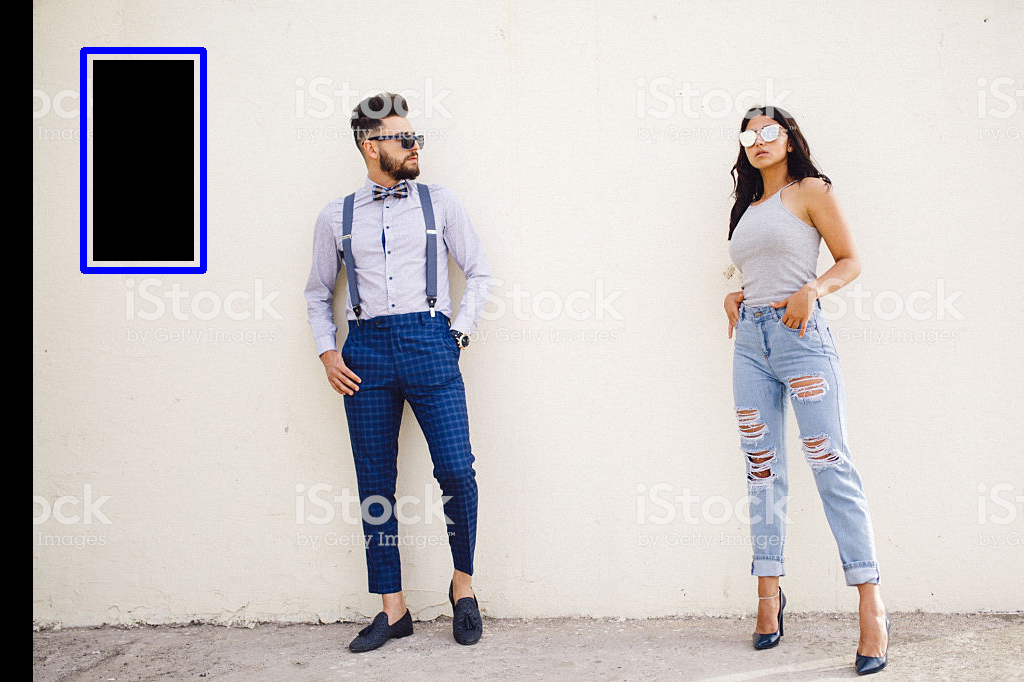

In [18]:
show = cv2.rectangle(np.array(tran_img), (bboxes[0][0]-5,bboxes[0][1]-5), (bboxes[0][2]+5,bboxes[0][3]+5), (255,0,0), 5)
to_pil(show)

In [75]:
tran = get_transform(cfg, cfg.TRAIN_TRANSFORM)

In [87]:
# temp = cv2.rectangle(temp, (60,60), (160,260), (0,0,0), -1)
temp = Image.open('/home/allen/two_people.jpg')
temp = to_pil(cv2.rectangle(np.array(temp), (60,60), (160,260), (0,0,0), -1))
bboxes = [np.array([55,55,165,265])]

t_img, state = tran(temp, bboxes)
show = cv2.rectangle(np.array(t_img), (bboxes[0][0]-5,bboxes[0][1]-5), (bboxes[0][2]+5,bboxes[0][3]+5), (255,0,0), 5)
state

[{'c': array([539., 551.], dtype=float32), 's': 716.8}]

In [89]:
bboxes

[array([ 0,  0,  0, 51])]

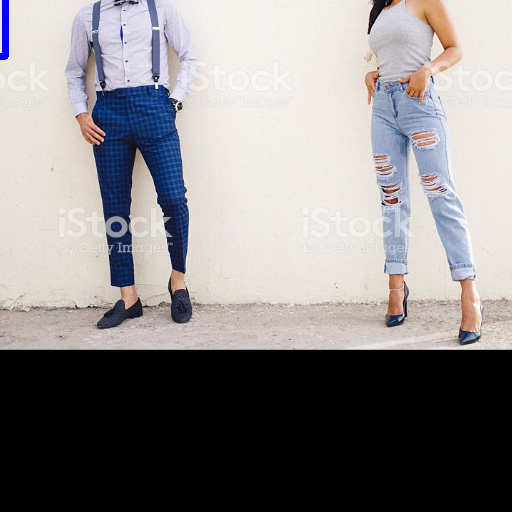

In [88]:
to_pil(show)

In [15]:
show = cv2.rectangle(np.array(temp), (bboxes[0][0],bboxes[0][1]), (bboxes[0][2],bboxes[0][3]), (255,0,0), 1)

In [9]:
class Base:
    def __init__(self, name):
        self.name = name
    
    @classmethod
    def __repr__(cls):
        return cls.__name__
class Aasdfas(Base):
    pass

In [10]:
a = Aasdfas(5)

In [11]:
print(a)

Aasdfas
